<h2>Building the Classifier</h2>

In [1]:
import tensorflow as tf
import cv2 as cv
import os
import random
import numpy as np
import pydot

from matplotlib import pyplot as plt

<h2>1. Defining Classifier</h2>

In [2]:
CLASSES = 4
model = tf.keras.models.Sequential([
    
    tf.keras.layers.Conv2D(16, kernel_size=3, activation='relu', input_shape=(224, 224, 1)),
    tf.keras.layers.AveragePooling2D(2,2),
    
    tf.keras.layers.Conv2D(32, kernel_size=3, activation = 'relu'),
    tf.keras.layers.AveragePooling2D(2,2),
    
    tf.keras.layers.Conv2D(64, kernel_size=3, activation = 'relu'),
    tf.keras.layers.AveragePooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation = 'relu'),
    
    tf.keras.layers.Dense(CLASSES, activation='softmax')
    
])

C:\Users\dzaki\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [3]:
def build_classifier(inputs):

    x = tf.keras.layers.Conv2D(16, kernel_size=3, activation='relu', input_shape=(input_size, input_size, 1))(inputs)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(32, kernel_size=3, activation = 'relu')(x)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(64, kernel_size=3, activation = 'relu')(x)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)
    
    x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    
    x = tf.keras.layers.Dense(CLASSES, activation='softmax')(x)

    return x

<h2>2. Building Regressor</h2>

In [4]:
def build_regressor(inputs):

    x = tf.keras.layers.Conv2D(16, kernel_size=3, activation='relu', input_shape=(input_size, input_size, 1))(inputs)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(32, kernel_size=3, activation = 'relu')(x)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(64, kernel_size=3, activation = 'relu')(x)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)
    
    x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    
    x = tf.keras.layers.Dense(units = '4')(inputs)(x)

    return x

In [5]:
def build_feature_extractor(inputs):

    x = tf.keras.layers.Conv2D(16, kernel_size=3, activation='relu', input_shape=(input_size, input_size, 1))(inputs)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(32, kernel_size=3, activation = 'relu')(x)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(64, kernel_size=3, activation = 'relu')(x)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    return x

def build_model_adaptor(inputs):
    x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    return x

def build_classifier_head(inputs):
    return tf.keras.layers.Dense(CLASSES, activation='softmax', name = 'classifier_head')(inputs)

def build_regressor_head(inputs):
    return tf.keras.layers.Dense(units = '4', name = 'regressor_head')(inputs)

def build_model(inputs):
    
    feature_extractor = build_feature_extractor(inputs)

    model_adaptor = build_model_adaptor(feature_extractor)

    classification_head = build_classifier_head(model_adaptor)

    regressor_head = build_regressor_head(model_adaptor)

    model = tf.keras.Model(inputs = inputs, outputs = [classification_head, regressor_head])

    return model

In [6]:
def list_files(full_data_path = "./obj/", image_ext = '.jpg', split_percentage = [70, 20]):
    
    files = []

    discarded = 0
    masked_instance = 0

    for r, d, f in os.walk(full_data_path):
        for file in f:
            if file.endswith(".txt"):

                # first, let's check if there is more than one object
                with open(full_data_path + "/" + file, 'r') as fp: 
                    lines = fp.readlines()
                    if len(lines) <= 1:
                        discarded += 1
                        continue
                    

                strip = file[0:len(file) - len(".txt")]  
                # secondly, check if the paired image actually exist
                image_path = full_data_path + "/" + strip + image_ext
                if os.path.isfile(image_path):
                    # checking the class. '0' means masked, '1' for unmasked
                    if lines[0][0] == '0':
                        masked_instance += 1
                    files.append(strip)

    size = len(files)   
    print(str(discarded) + " file(s) discarded")
    print(str(size) + " valid case(s)")
    print(str(masked_instance) + " are masked cases")

    random.shuffle(files)

    split_training = int(split_percentage[0] * size / 100)
    split_validation = split_training + int(split_percentage[1] * size / 100)

    return files[0:split_training], files[split_training:split_validation], files[split_validation:]
    
training_files, validation_files, test_files = list_files()

print(str(len(training_files)) + " training files")
print(str(len(validation_files)) + " validation files")
print(str(len(test_files)) + " test files")

1 file(s) discarded
770 valid case(s)
2 are masked cases
539 training files
154 validation files
77 test files


In [7]:
input_size = 244

def format_image(img, box):
    height, width = img.shape 
    max_size = max(height, width)
    r = max_size / input_size
    new_width = int(width / r)
    new_height = int(height / r)
    new_size = (new_width, new_height)
    resized = cv.resize(img, new_size, interpolation= cv.INTER_LINEAR)
    new_image = np.zeros((input_size, input_size), dtype=np.uint8)
    new_image[0:new_height, 0:new_width] = resized

    x, y, w, h = box[0], box[1], box[2], box[3]
    new_box = [int((x - 0.5*w)* width / r), int((y - 0.5*h) * height / r), int(w*width / r), int(h*height / r)]

    return new_image, new_box

<h2>Demonstrasi Cara Melakukan Plotting Boundary Box</h2>

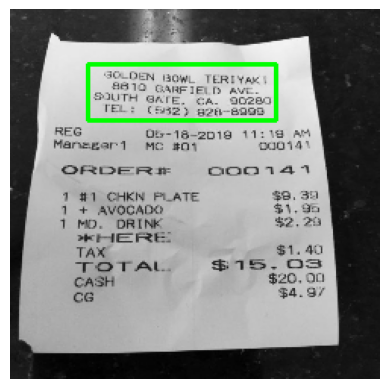

In [8]:
temp_img = cv.imread("./obj/0_jpg.rf.edfc36b893bb5852b605b16fba630ac5.jpg", cv.IMREAD_GRAYSCALE)
temp_box = [0.46796875, 0.2296875, 0.51328125, 0.15703125]

temp_img_formated, box = format_image(temp_img, temp_box)

temp_color_img = cv.cvtColor(temp_img_formated, cv.COLOR_GRAY2RGB)

cv.rectangle(temp_color_img, box, (0, 255, 0), 2)

plt.imshow(temp_color_img)
plt.axis("off")
plt.show()

<h2>Building Model for Receipt Object Detection</h2>

In [9]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # disabling verbose tf logging

# uncomment the following line if you want to force CPU
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
print(tf.__version__)

2.18.0


In [10]:
line_to_be_read = 0

def data_load(files, full_data_path = "./obj/", image_ext = ".jpg"):
    X = []
    Y = []

    for file in files:
        img = cv.imread(os.path.join(full_data_path, file + image_ext), cv.IMREAD_GRAYSCALE)

        k = 1

        with open(full_data_path + "/" + file + ".txt", 'r') as fp: 
            line = fp.readlines()[line_to_be_read]
            if line[0] == '0':
                k = 0

            box = np.array(line[1:].split(), dtype=float)

        img, box = format_image(img, box)
        img = img.astype(float) / 255.
        box = np.asarray(box, dtype=float) / input_size
        label = np.append(box, k)

        X.append(img)
        Y.append(label)

    X = np.array(X)
    
    X = np.expand_dims(X, axis=3)

    X = tf.convert_to_tensor(X, dtype=tf.float32)

    Y = tf.convert_to_tensor(Y, dtype=tf.float32)

    result = tf.data.Dataset.from_tensor_slices((X, Y))

    return result

<u><h3>Keterangan Tambahan</h3></u>
<p>
    line_to_be_read :
    <ul>
        <li>0 = Seluruh Struk Belanja</li>
        <li>1 = Info Toko</li>
        <li>2 = Daftar Belanjaan</li>
        <li>3 = Total</li>
    </ul>
</p>

In [11]:
raw_train_ds = data_load(training_files)

In [12]:
raw_validation_ds = data_load(validation_files)

In [13]:
raw_test_ds = data_load(test_files)

In [14]:
CLASSES = 2

def format_instance(image, label):
    return image, (tf.one_hot(int(label[4]), CLASSES), [label[0], label[1], label[2], label[3]])

In [15]:
BATCH_SIZE = 32

# see https://www.tensorflow.org/guide/data_performance

def tune_training_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(1024, reshuffle_each_iteration=True)
    dataset = dataset.repeat() # The dataset be repeated indefinitely.
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [16]:
train_ds = tune_training_ds(raw_train_ds)

In [17]:
def tune_validation_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(len(validation_files) // 4)
    dataset = dataset.repeat()
    return dataset

In [18]:
validation_ds = tune_validation_ds(raw_validation_ds)

<h2>Inspect Dataset</h2>

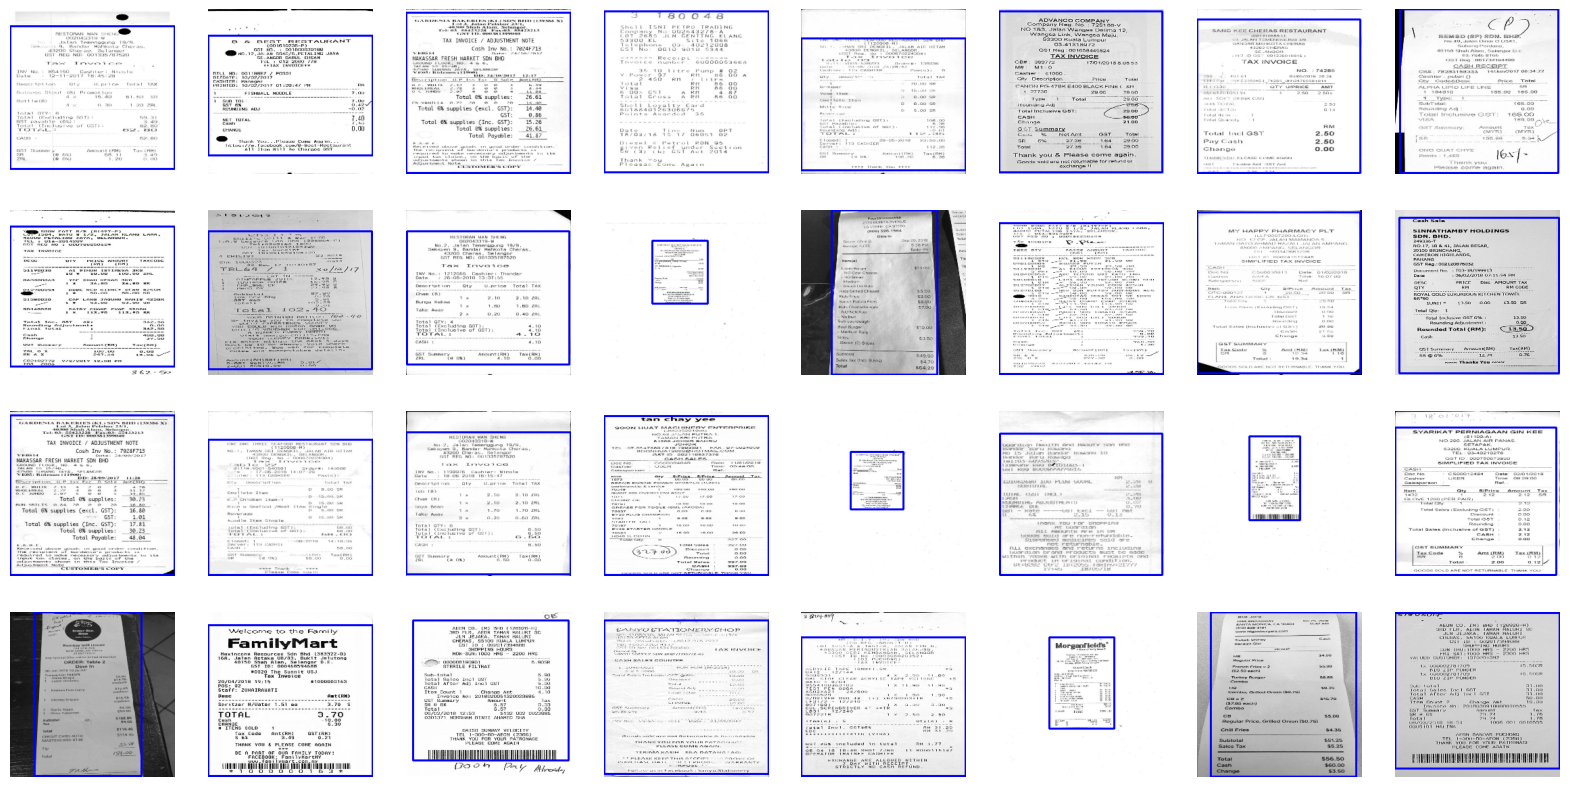

In [19]:
plt.figure(figsize=(20, 10))
for images, labels in train_ds.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(4, BATCH_SIZE//4, i + 1)
        label = labels[0][i]
        box = (labels[1][i] * input_size)
        box = tf.cast(box, tf.int32)

        image = images[i].numpy().astype("float") * 255.0
        image = image.astype(np.uint8)
        image_color = cv.cvtColor(image, cv.COLOR_GRAY2RGB)

        color = (0, 0, 255)
        if label[0] > 0:
            color = (0, 255, 0)

        cv.rectangle(image_color, box.numpy(), color, 2)

        plt.imshow(image_color)
        plt.axis("off")

<h2>The Model</h2>

In [43]:
DROPOUT_FACTOR = 0.5

def build_feature_extractor(inputs):
    x = tf.keras.Input(shape=(input_size, input_size, 1,))
    x = tf.keras.layers.Conv2D(16, kernel_size=3, activation='relu')(inputs)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(32, kernel_size=3, activation = 'relu')(x)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(64, kernel_size=3, activation = 'relu')(x)
    x = tf.keras.layers.Dropout(DROPOUT_FACTOR)(x)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    return x

def build_model_adaptor(inputs):
  x = tf.keras.layers.Flatten()(inputs)
  x = tf.keras.layers.Dense(64, activation='relu')(x)
  return x

def build_classifier_head(inputs):
  return tf.keras.layers.Dense(CLASSES, activation='softmax', name = 'classifier_head')(inputs)

def build_regressor_head(inputs):
    #return tf.keras.layers.Dense(units = '4', name = 'regressor_head')(inputs)
    return tf.keras.layers.Dense(units=4, name='regressor_head')(inputs)

def build_model(inputs):
    
    feature_extractor = build_feature_extractor(inputs)

    model_adaptor = build_model_adaptor(feature_extractor)

    classification_head = build_classifier_head(model_adaptor)

    regressor_head = build_regressor_head(model_adaptor)

    model = tf.keras.Model(inputs = inputs, outputs = [classification_head, regressor_head])

    model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss = {'classifier_head' : 'categorical_crossentropy', 'regressor_head' : 'mse' }, 
              metrics = {'classifier_head' : 'accuracy', 'regressor_head' :  'mse'})

    return model

In [44]:
model = build_model(tf.keras.layers.Input(shape=(input_size, input_size, 1,)))

model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)   │ (None, 244, 244, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_24 (Conv2D)            │ (None, 242, 242, 16)      │             160 │ input_layer_15[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ average_pooling2d_24          │ (None, 121, 121, 16)      │               0 │ conv2d_24[0][0]            │
│ (AveragePooling2D)            │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_25 (Conv2D)            │ (None, 119, 119, 32)      │           4,640 │ average_pooling2d_24[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ average_pooling2d_25          │ (None, 59, 59, 32)        │               0 │ conv2d_25[0][0]            │
│ (AveragePooling2D)            │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_26 (Conv2D)            │ (None, 57, 57, 64)        │          18,496 │ average_pooling2d_25[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_7 (Dropout)           │ (None, 57, 57, 64)        │               0 │ conv2d_26[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ average_pooling2d_26          │ (None, 28, 28, 64)        │               0 │ dropout_7[0][0]            │
│ (AveragePooling2D)            │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_8 (Flatten)           │ (None, 50176)             │               0 │ average_pooling2d_26[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_9 (Dense)               │ (None, 64)                │       3,211,328 │ flatten_8[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ classifier_head (Dense)       │ (None, 2)                 │             130 │ dense_9[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ regressor_head (Dense)        │ (None, 4)                 │             260 │ dense_9[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 3,235,014 (12.34 MB)

 Trainable params: 3,235,014 (12.34 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
!pip install pydot
import pydot

<h2>Model Training</h2>

In [45]:
EPOCHS = 100

history = model.fit(train_ds,
                    steps_per_epoch=(len(training_files) // BATCH_SIZE),
                    validation_data=validation_ds, validation_steps=1,
                    epochs=EPOCHS,
                    verbose=1)


Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 250ms/step - classifier_head_accuracy: 0.7939 - classifier_head_loss: 0.2502 - loss: 1.8969 - regressor_head_loss: 1.6467 - regressor_head_mse: 1.6467 - val_classifier_head_accuracy: 1.0000 - val_classifier_head_loss: 0.0193 - val_loss: 0.0744 - val_regressor_head_loss: 0.0551 - val_regressor_head_mse: 0.0551
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 233ms/step - classifier_head_accuracy: 0.9979 - classifier_head_loss: 0.0253 - loss: 0.0758 - regressor_head_loss: 0.0505 - regressor_head_mse: 0.0505 - val_classifier_head_accuracy: 0.9737 - val_classifier_head_loss: 0.1842 - val_loss: 0.2070 - val_regressor_head_loss: 0.0228 - val_regressor_head_mse: 0.0228
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 272ms/step - classifier_head_accuracy: 0.9984 - classifier_head_loss: 0.0134 - loss: 0.0427 - regressor_head_loss: 0.0292 - regressor_head_mse: 0.0292 - val_classifier_head_accuracy: 1.0000 - val_classifier_head_loss: 0.0045 - val_loss: 0.0362 - val_re

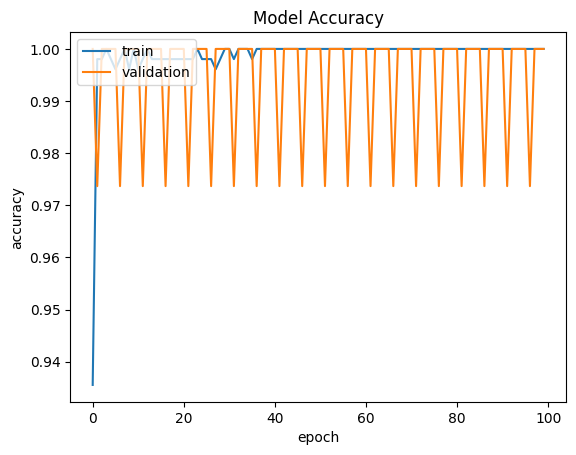

In [46]:
plt.plot(history.history['classifier_head_accuracy'])
plt.plot(history.history['val_classifier_head_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

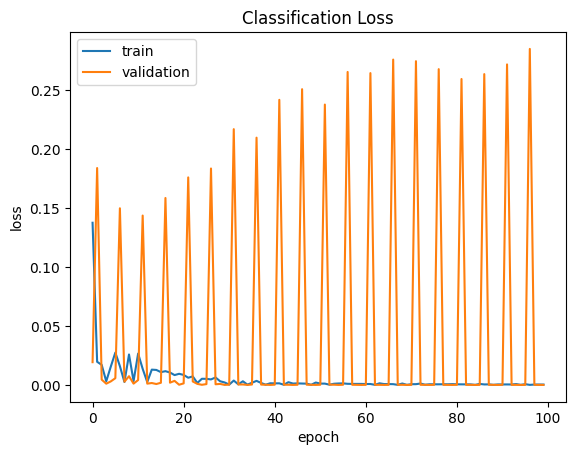

In [47]:
plt.plot(history.history['classifier_head_loss'])
plt.plot(history.history['val_classifier_head_loss'])
plt.title('Classification Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

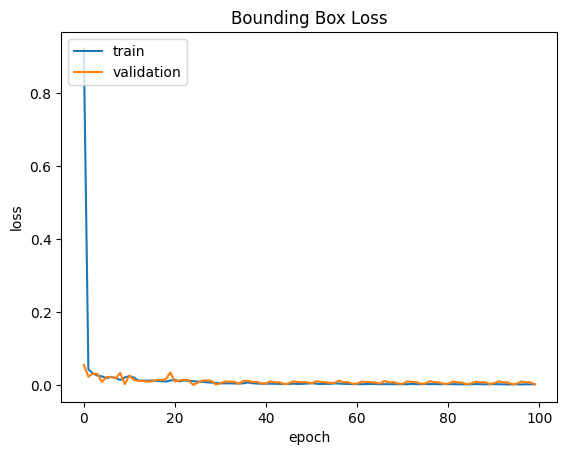

In [48]:
plt.plot(history.history['regressor_head_loss'])
plt.plot(history.history['val_regressor_head_loss'])
plt.title('Bounding Box Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

<h2>Evaluation</h2>

In [49]:
# adapted from: https://pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
def intersection_over_union(boxA, boxB):
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
	yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	boxAArea = (boxA[2] + 1) * (boxA[3] + 1)
	boxBArea = (boxB[2] + 1) * (boxB[3] + 1)
	iou = interArea / float(boxAArea + boxBArea - interArea)
	return iou

In [50]:
def tune_test_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(1) 
    dataset = dataset.repeat()
    return dataset

test_ds = tune_test_ds(raw_test_ds)

20


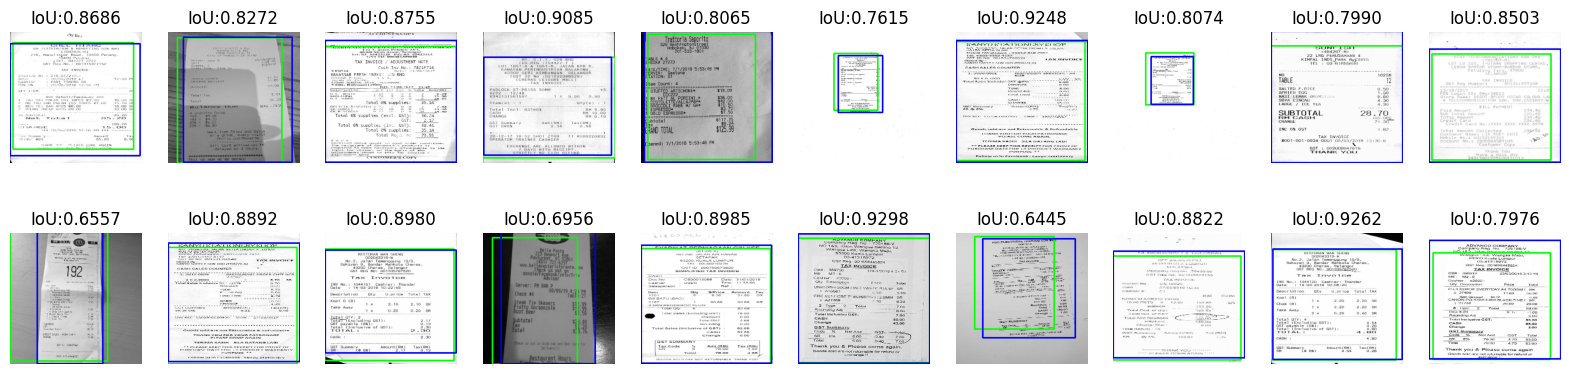

In [51]:
plt.figure(figsize=(20, 10))

test_list = list(test_ds.take(20).as_numpy_iterator())

print(len(test_list))

image, labels = test_list[0]

for i in range(len(test_list)):

    ax = plt.subplot(4, 10, i + 1)
    image, labels = test_list[i]

    predictions = model(image)

    predicted_box = predictions[1][0] * input_size
    predicted_box = tf.cast(predicted_box, tf.int32)

    predicted_label = predictions[0][0]

    image = image[0]

    actual_label = labels[0][0]
    actual_box = labels[1][0] * input_size
    actual_box = tf.cast(actual_box, tf.int32)

    image = image.astype("float") * 255.0
    image = image.astype(np.uint8)
    image_color = cv.cvtColor(image, cv.COLOR_GRAY2RGB)

    color = (255, 0, 0)
    # print box red if predicted and actual label do not match
    if (predicted_label[0] > 0.5 and actual_label[0] > 0) or (predicted_label[0] < 0.5 and actual_label[0] == 0):
        color = (0, 255, 0)

    cv.rectangle(image_color, predicted_box.numpy(), color, 2)
    cv.rectangle(image_color, actual_box.numpy(), (0, 0, 255), 2)

    IoU = intersection_over_union(predicted_box.numpy(), actual_box.numpy())

    plt.title("IoU:" + format(IoU, '.4f'))
    plt.imshow(image_color)
    plt.axis("off")

<h2>Test Deployment</h2>

In [120]:
import re
from statistics import mean

def path_norm(image_path):
    image_path = re.sub(r'\\','/',image_path)
    return image_path

def obj_detect(image_path):
    image_path = path_norm(image_path)
    img = cv.imread(image_path, cv.IMREAD_GRAYSCALE)

    #preprocess image
    height, width = img.shape 
    max_size = max(height, width)
    r = max_size / input_size
    new_width = int(width / r)
    new_height = int(height / r)
    new_size = (new_width, new_height)
    resized = cv.resize(img, new_size, interpolation= cv.INTER_LINEAR)
    new_image = np.zeros((input_size, input_size), dtype=np.uint8)
    new_image[0:new_height, 0:new_width] = resized

    #second preprocessing
    X = [] 
    new_image = new_image.astype(float) / 255.

    X.append(new_image)

    #third preprocessing
    X = np.array(X)
    
    X = np.expand_dims(X, axis=3)

    X = tf.convert_to_tensor(X, dtype=tf.float32)

    result = X
    #fourth preprocessing 
    predictions = model(result)

    predicted_box = abs(predictions[1][0] * max_size)
    
    predicted_box = tf.cast(predicted_box, tf.int32)
    
    temp_color_img = cv.cvtColor(img, cv.COLOR_GRAY2RGB)

    temp_color_img = cv.rectangle(temp_color_img, predicted_box.numpy(), color, 2)

    plt.imshow(temp_color_img)
    plt.axis("off")
    plt.show()
    
    return(predicted_box)

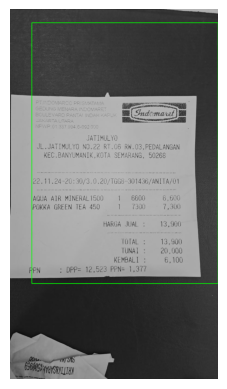

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([  94,   59, 1044, 1128])>

In [121]:
obj_detect(r'C:\Users\dzaki\Downloads\test_indomaret.jpeg')

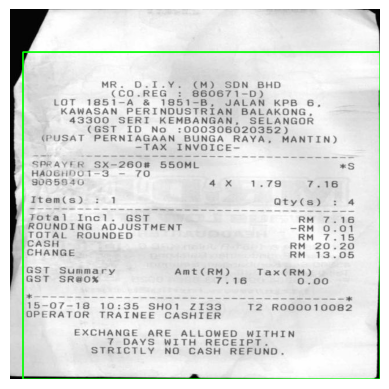

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 22,  74, 679, 568])>

In [122]:
obj_detect(r'C:\Users\dzaki\Downloads\test_indomaret2.jpg')

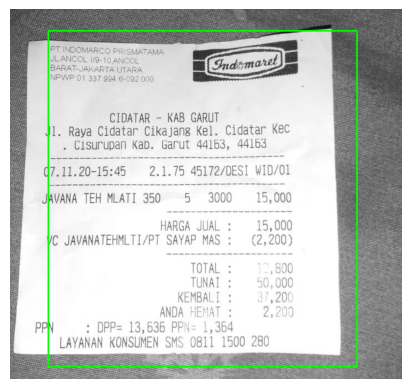

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 69,  39, 560, 609])>

In [123]:
obj_detect(r'C:\Users\dzaki\Downloads\test_indomaret3.jpg')

<h2>Building Model for Store Information</h2>

In [83]:
line_to_be_read = 1
raw_train_ds_1 = data_load(training_files)
raw_validation_ds_1 = data_load(validation_files)
raw_test_ds_1 = data_load(test_files)

In [84]:
train_ds_1 = tune_training_ds(raw_train_ds_1)
validation_ds_1 = tune_validation_ds(raw_validation_ds_1)

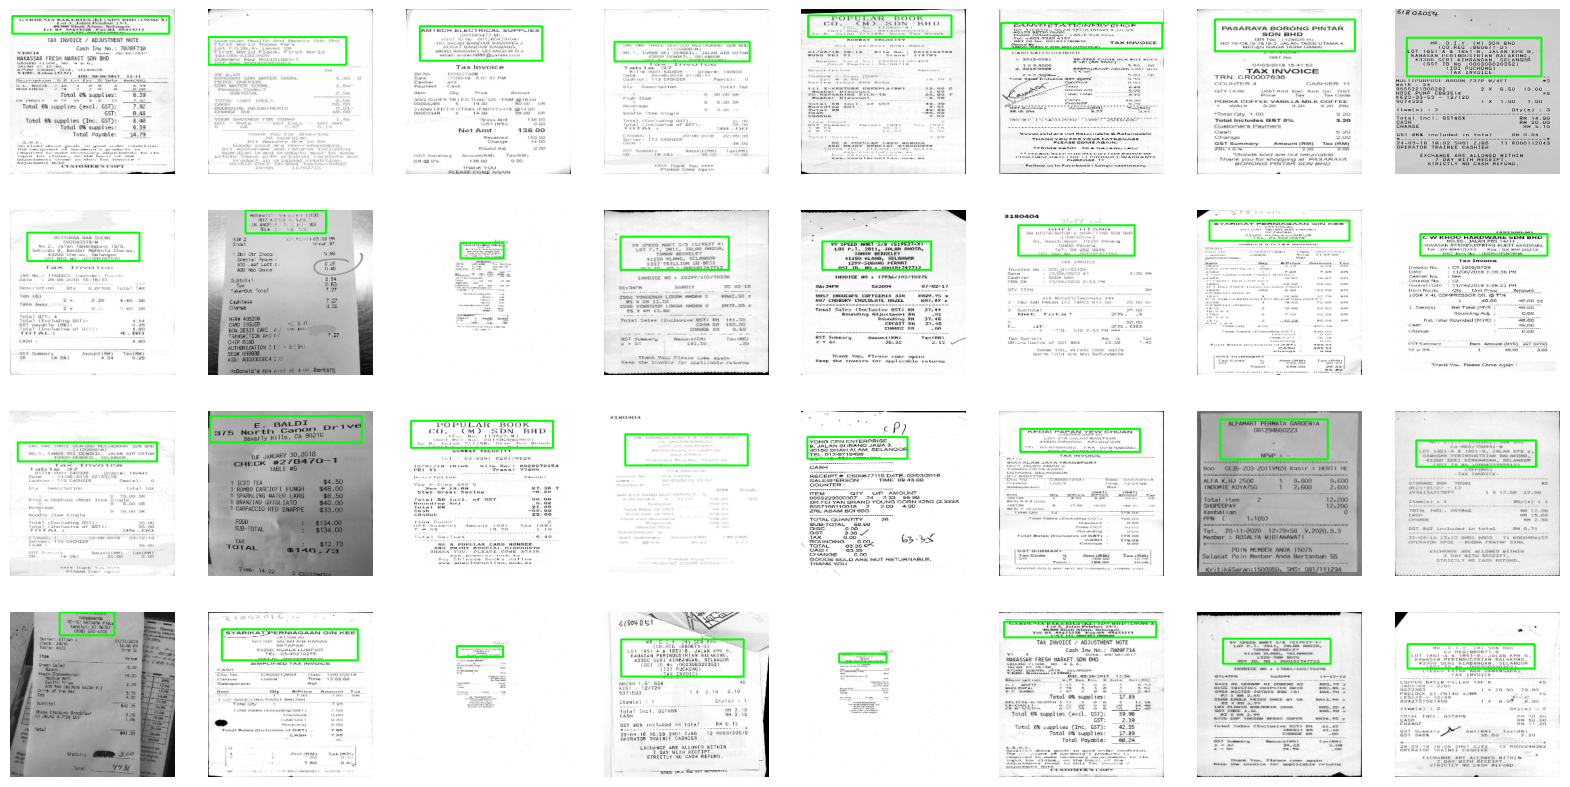

In [85]:
plt.figure(figsize=(20, 10))
for images, labels in train_ds_1.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(4, BATCH_SIZE//4, i + 1)
        label = labels[0][i]
        box = (labels[1][i] * input_size)
        box = tf.cast(box, tf.int32)

        image = images[i].numpy().astype("float") * 255.0
        image = image.astype(np.uint8)
        image_color = cv.cvtColor(image, cv.COLOR_GRAY2RGB)

        color = (0, 0, 255)
        if label[0] > 0:
            color = (0, 255, 0)

        cv.rectangle(image_color, box.numpy(), color, 2)

        plt.imshow(image_color)
        plt.axis("off")

In [86]:
model_1 = build_model(tf.keras.layers.Input(shape=(input_size, input_size, 1,)))

model_1.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)   │ (None, 244, 244, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_27 (Conv2D)            │ (None, 242, 242, 16)      │             160 │ input_layer_17[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ average_pooling2d_27          │ (None, 121, 121, 16)      │               0 │ conv2d_27[0][0]            │
│ (AveragePooling2D)            │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_28 (Conv2D)            │ (None, 119, 119, 32)      │           4,640 │ average_pooling2d_27[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ average_pooling2d_28          │ (None, 59, 59, 32)        │               0 │ conv2d_28[0][0]            │
│ (AveragePooling2D)            │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_29 (Conv2D)            │ (None, 57, 57, 64)        │          18,496 │ average_pooling2d_28[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_8 (Dropout)           │ (None, 57, 57, 64)        │               0 │ conv2d_29[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ average_pooling2d_29          │ (None, 28, 28, 64)        │               0 │ dropout_8[0][0]            │
│ (AveragePooling2D)            │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_9 (Flatten)           │ (None, 50176)             │               0 │ average_pooling2d_29[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_10 (Dense)              │ (None, 64)                │       3,211,328 │ flatten_9[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ classifier_head (Dense)       │ (None, 2)                 │             130 │ dense_10[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ regressor_head (Dense)        │ (None, 4)                 │             260 │ dense_10[0][0]             │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 3,235,014 (12.34 MB)

 Trainable params: 3,235,014 (12.34 MB)

 Non-trainable params: 0 (0.00 B)

In [87]:
EPOCHS = 100

history = model_1.fit(train_ds_1,
                    steps_per_epoch=(len(training_files) // BATCH_SIZE),
                    validation_data=validation_ds_1, validation_steps=1,
                    epochs=EPOCHS,
                    verbose=1)


Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 256ms/step - classifier_head_accuracy: 0.8080 - classifier_head_loss: 0.1959 - loss: 0.6904 - regressor_head_loss: 0.4944 - regressor_head_mse: 0.4944 - val_classifier_head_accuracy: 0.9737 - val_classifier_head_loss: 0.1406 - val_loss: 0.1705 - val_regressor_head_loss: 0.0299 - val_regressor_head_mse: 0.0299
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 284ms/step - classifier_head_accuracy: 0.9958 - classifier_head_loss: 0.0385 - loss: 0.0624 - regressor_head_loss: 0.0238 - regressor_head_mse: 0.0238 - val_classifier_head_accuracy: 0.9737 - val_classifier_head_loss: 0.1326 - val_loss: 0.1525 - val_regressor_head_loss: 0.0200 - val_regressor_head_mse: 0.0200
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 311ms/step - classifier_head_accuracy: 0.9922 - classifier_head_loss: 0.0472 - loss: 0.0687 - regressor_head_loss: 0.0215 - regressor_head_mse: 0.0215 - val_classifier_head_accuracy: 0.9474 - val_classifier_head_loss: 0.2592 - val_loss: 0.2819 - val_re

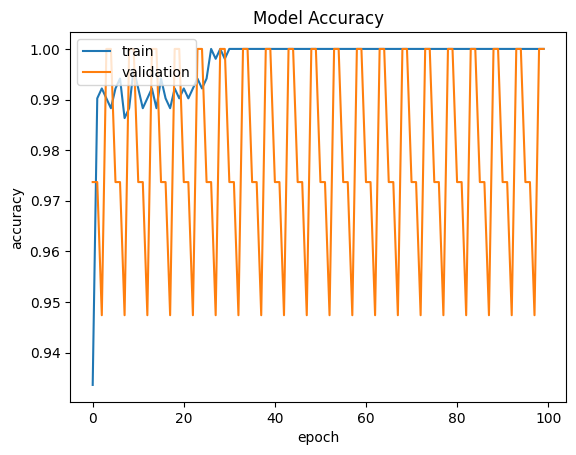

In [88]:
plt.plot(history.history['classifier_head_accuracy'])
plt.plot(history.history['val_classifier_head_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

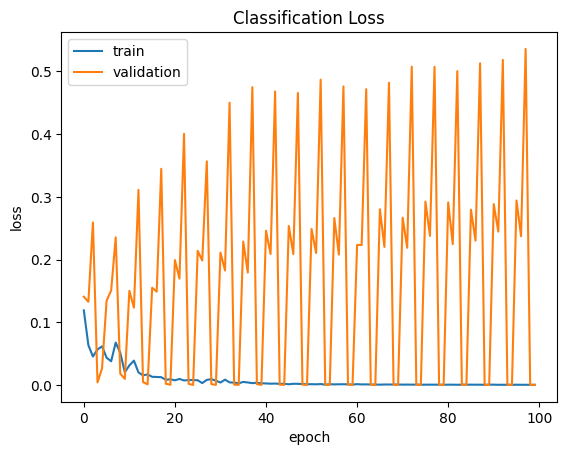

In [89]:
plt.plot(history.history['classifier_head_loss'])
plt.plot(history.history['val_classifier_head_loss'])
plt.title('Classification Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

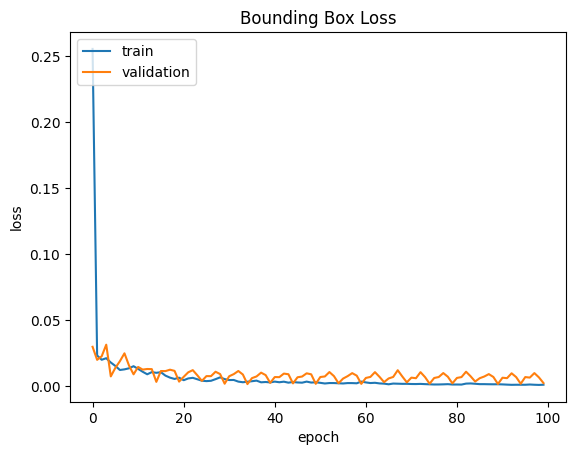

In [90]:
plt.plot(history.history['regressor_head_loss'])
plt.plot(history.history['val_regressor_head_loss'])
plt.title('Bounding Box Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

20


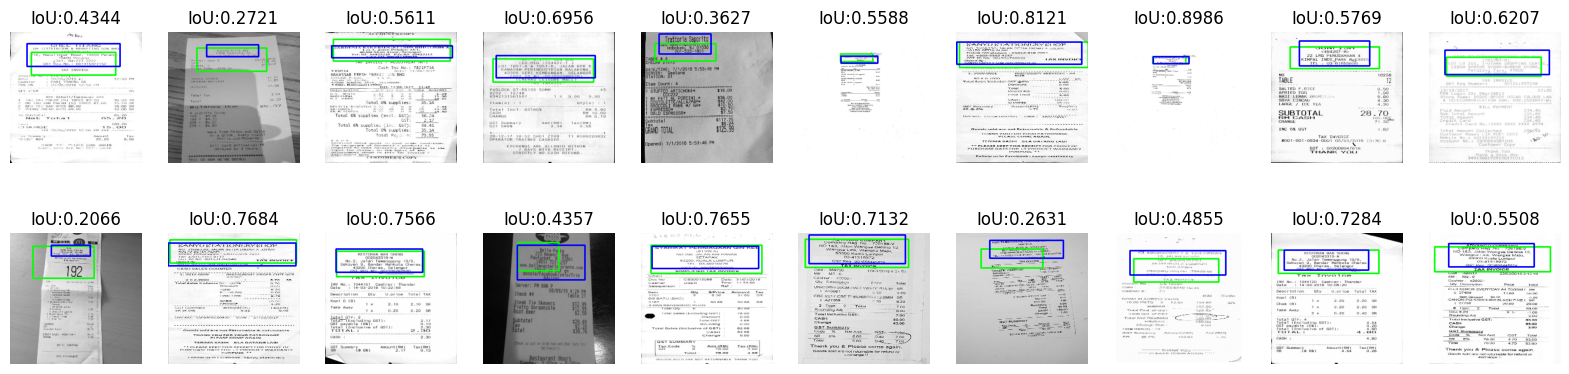

In [124]:
test_ds_1 = tune_test_ds(raw_test_ds_1) #

plt.figure(figsize=(20, 10))

test_list_1 = list(test_ds_1.take(20).as_numpy_iterator()) #

print(len(test_list_1)) #

image, labels = test_list_1[0] #

for i in range(len(test_list_1)):

    ax = plt.subplot(4, 10, i + 1)
    image, labels = test_list_1[i] #

    predictions = model_1(image) #

    predicted_box = abs(predictions[1][0] * input_size)
    predicted_box = tf.cast(predicted_box, tf.int32)

    predicted_label = predictions[0][0]

    image = image[0]

    actual_label = labels[0][0]
    actual_box = labels[1][0] * input_size
    actual_box = tf.cast(actual_box, tf.int32)

    image = image.astype("float") * 255.0
    image = image.astype(np.uint8)
    image_color = cv.cvtColor(image, cv.COLOR_GRAY2RGB)

    color = (255, 0, 0)
    # print box red if predicted and actual label do not match
    if (predicted_label[0] > 0.5 and actual_label[0] > 0) or (predicted_label[0] < 0.5 and actual_label[0] == 0):
        color = (0, 255, 0)

    cv.rectangle(image_color, predicted_box.numpy(), color, 2)
    cv.rectangle(image_color, actual_box.numpy(), (0, 0, 255), 2)

    IoU = intersection_over_union(predicted_box.numpy(), actual_box.numpy())

    plt.title("IoU:" + format(IoU, '.4f'))
    plt.imshow(image_color)
    plt.axis("off")

In [125]:
def obj_detect_1(image_path):
    image_path = path_norm(image_path)
    img = cv.imread(image_path, cv.IMREAD_GRAYSCALE)

    #preprocess image
    height, width = img.shape 
    max_size = max(height, width)
    r = max_size / input_size
    new_width = int(width / r)
    new_height = int(height / r)
    new_size = (new_width, new_height)
    resized = cv.resize(img, new_size, interpolation= cv.INTER_LINEAR)
    new_image = np.zeros((input_size, input_size), dtype=np.uint8)
    new_image[0:new_height, 0:new_width] = resized

    #second preprocessing
    X = [] 
    new_image = new_image.astype(float) / 255.

    X.append(new_image)

    #third preprocessing
    X = np.array(X)
    
    X = np.expand_dims(X, axis=3)

    X = tf.convert_to_tensor(X, dtype=tf.float32)

    result = X
    #fourth preprocessing 
    predictions = model_1(result)

    predicted_box = abs(predictions[1][0] * max_size)
    
    predicted_box = tf.cast(predicted_box, tf.int32)
    
    temp_color_img = cv.cvtColor(img, cv.COLOR_GRAY2RGB)

    temp_color_img = cv.rectangle(temp_color_img, predicted_box.numpy(), color, 2)

    plt.imshow(temp_color_img)
    plt.axis("off")
    plt.show()
    
    return(predicted_box)

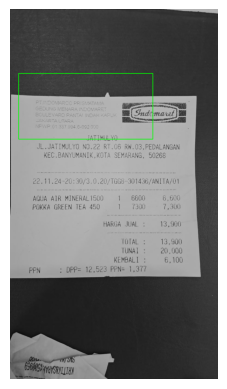

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 37, 278, 581, 285])>

In [126]:
obj_detect_1(r'C:\Users\dzaki\Downloads\test_indomaret.jpeg')

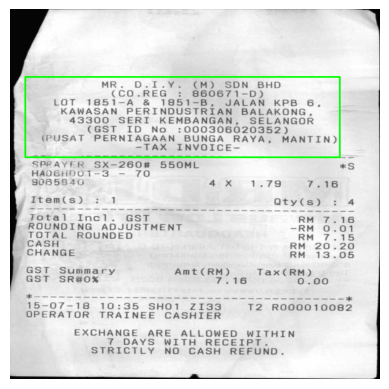

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 26, 117, 545, 140])>

In [127]:
obj_detect_1(r'C:\Users\dzaki\Downloads\test_indomaret2.jpg')

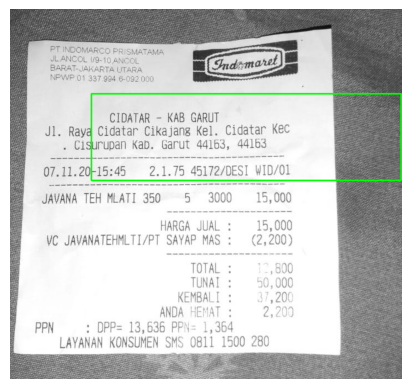

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([147, 153, 562, 158])>

In [128]:
obj_detect_1(r'C:\Users\dzaki\Downloads\test_indomaret3.jpg')

<h2>Building Model for Purchased Items</h2>

In [98]:
line_to_be_read = 2
raw_train_ds_2 = data_load(training_files)
raw_validation_ds_2 = data_load(validation_files)
raw_test_ds_2 = data_load(test_files)

In [99]:
train_ds_2 = tune_training_ds(raw_train_ds_2)
validation_ds_2 = tune_validation_ds(raw_validation_ds_2)

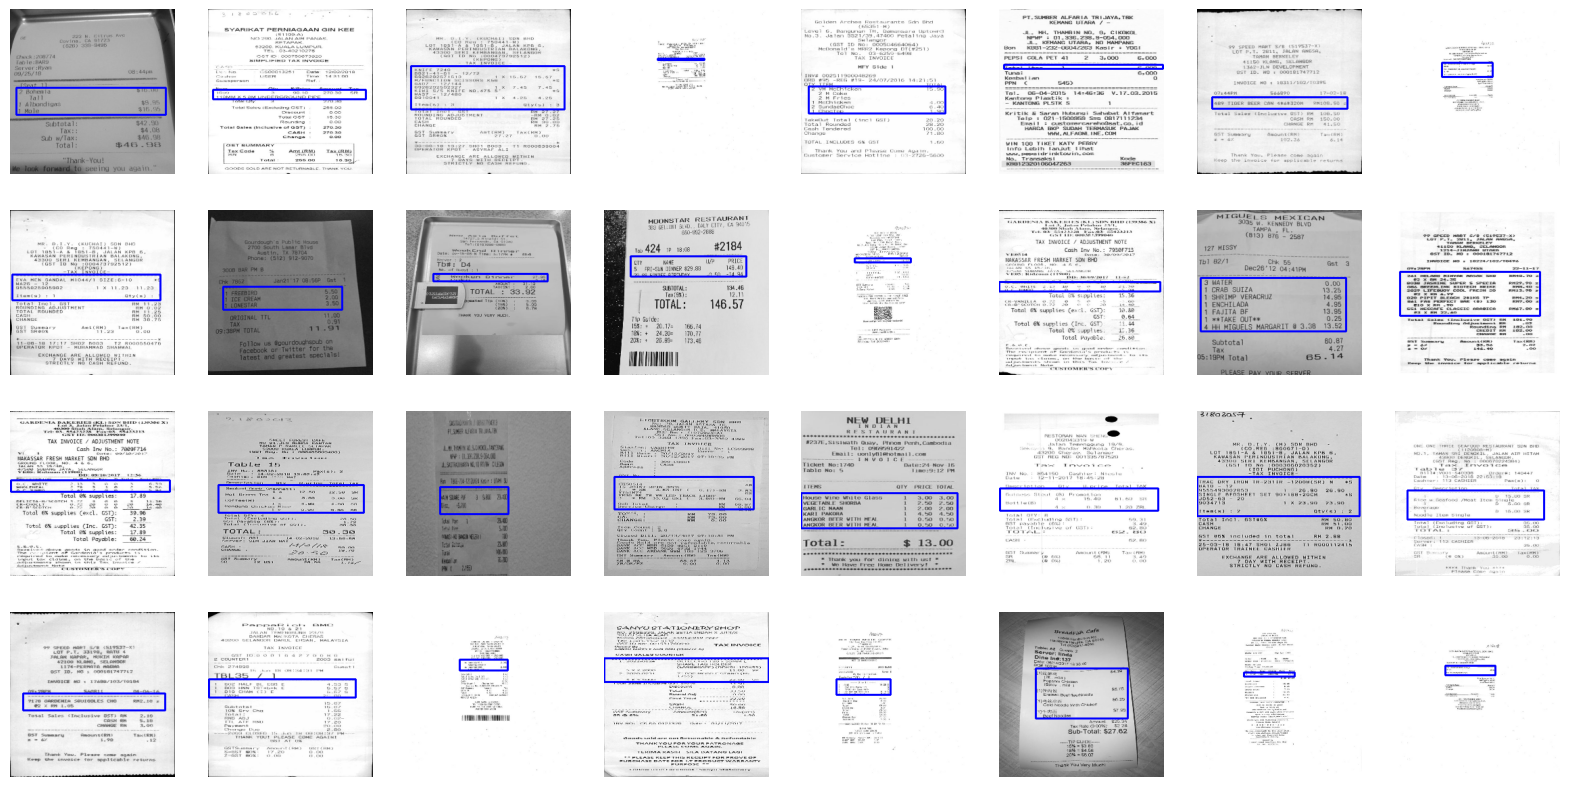

In [100]:
plt.figure(figsize=(20, 10))
for images, labels in train_ds_2.take(1): #
    for i in range(BATCH_SIZE):
        ax = plt.subplot(4, BATCH_SIZE//4, i + 1)
        label = labels[0][i]
        box = (labels[1][i] * input_size)
        box = tf.cast(box, tf.int32)

        image = images[i].numpy().astype("float") * 255.0
        image = image.astype(np.uint8)
        image_color = cv.cvtColor(image, cv.COLOR_GRAY2RGB)

        color = (0, 0, 255)
        if label[0] > 0:
            color = (0, 255, 0)

        cv.rectangle(image_color, box.numpy(), color, 2)

        plt.imshow(image_color)
        plt.axis("off")

In [101]:
model_2 = build_model(tf.keras.layers.Input(shape=(input_size, input_size, 1,)))

model_2.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)   │ (None, 244, 244, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_30 (Conv2D)            │ (None, 242, 242, 16)      │             160 │ input_layer_19[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ average_pooling2d_30          │ (None, 121, 121, 16)      │               0 │ conv2d_30[0][0]            │
│ (AveragePooling2D)            │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_31 (Conv2D)            │ (None, 119, 119, 32)      │           4,640 │ average_pooling2d_30[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ average_pooling2d_31          │ (None, 59, 59, 32)        │               0 │ conv2d_31[0][0]            │
│ (AveragePooling2D)            │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_32 (Conv2D)            │ (None, 57, 57, 64)        │          18,496 │ average_pooling2d_31[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_9 (Dropout)           │ (None, 57, 57, 64)        │               0 │ conv2d_32[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ average_pooling2d_32          │ (None, 28, 28, 64)        │               0 │ dropout_9[0][0]            │
│ (AveragePooling2D)            │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_10 (Flatten)          │ (None, 50176)             │               0 │ average_pooling2d_32[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_11 (Dense)              │ (None, 64)                │       3,211,328 │ flatten_10[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ classifier_head (Dense)       │ (None, 2)                 │             130 │ dense_11[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ regressor_head (Dense)        │ (None, 4)                 │             260 │ dense_11[0][0]             │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 3,235,014 (12.34 MB)

 Trainable params: 3,235,014 (12.34 MB)

 Non-trainable params: 0 (0.00 B)

In [102]:
EPOCHS = 100

history = model_2.fit(train_ds_2,
                    steps_per_epoch=(len(training_files) // BATCH_SIZE),
                    validation_data=validation_ds_2, validation_steps=1,
                    epochs=EPOCHS,
                    verbose=1)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 262ms/step - classifier_head_accuracy: 0.9850 - classifier_head_loss: 0.2436 - loss: 1.6131 - regressor_head_loss: 1.3695 - regressor_head_mse: 1.3695 - val_classifier_head_accuracy: 1.0000 - val_classifier_head_loss: 0.0033 - val_loss: 0.1317 - val_regressor_head_loss: 0.1284 - val_regressor_head_mse: 0.1284
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 249ms/step - classifier_head_accuracy: 0.9907 - classifier_head_loss: 0.0545 - loss: 0.1220 - regressor_head_loss: 0.0675 - regressor_head_mse: 0.0675 - val_classifier_head_accuracy: 1.0000 - val_classifier_head_loss: 0.0037 - val_loss: 0.0208 - val_regressor_head_loss: 0.0172 - val_regressor_head_mse: 0.0172
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 250ms/step - classifier_head_accuracy: 0.9955 - classifier_head_loss: 0.0275 - loss: 0.0521 - regressor_head_loss: 0.0246 - regressor_head_mse: 0.0246 - val_classifier_head_accuracy: 0.9737 - val_classifier_head_loss: 0.1784 - val_loss: 0.2019 - val_re

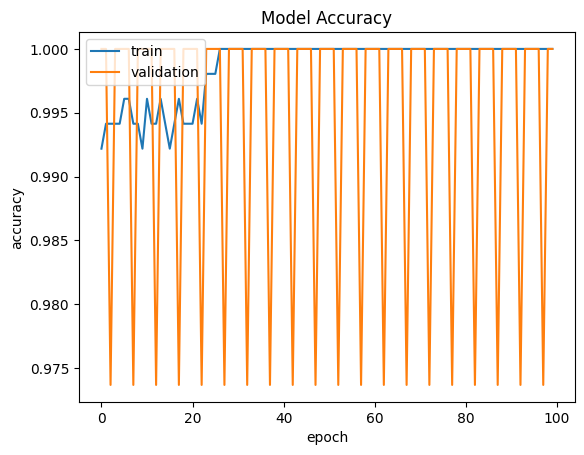

In [103]:
plt.plot(history.history['classifier_head_accuracy'])
plt.plot(history.history['val_classifier_head_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

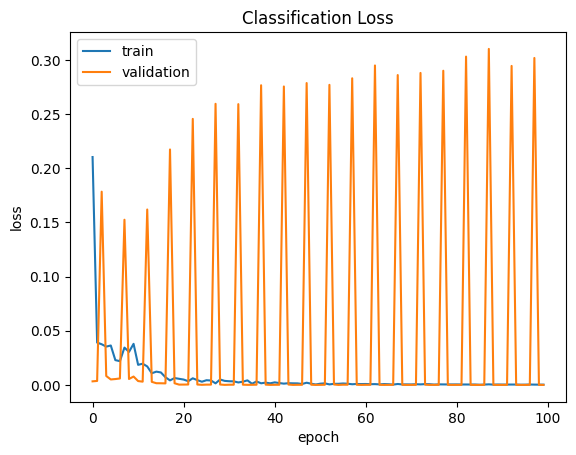

In [104]:
plt.plot(history.history['classifier_head_loss'])
plt.plot(history.history['val_classifier_head_loss'])
plt.title('Classification Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

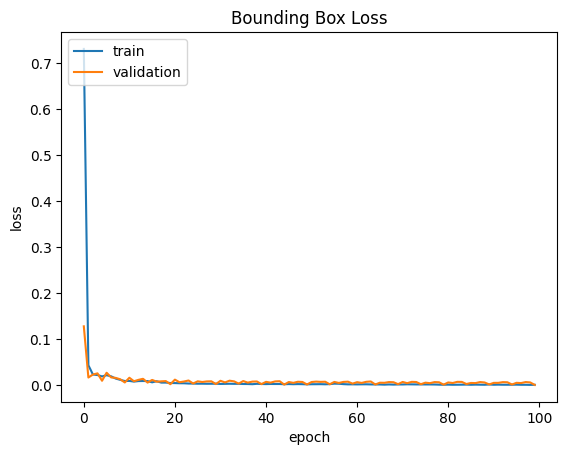

In [105]:
plt.plot(history.history['regressor_head_loss'])
plt.plot(history.history['val_regressor_head_loss'])
plt.title('Bounding Box Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

20


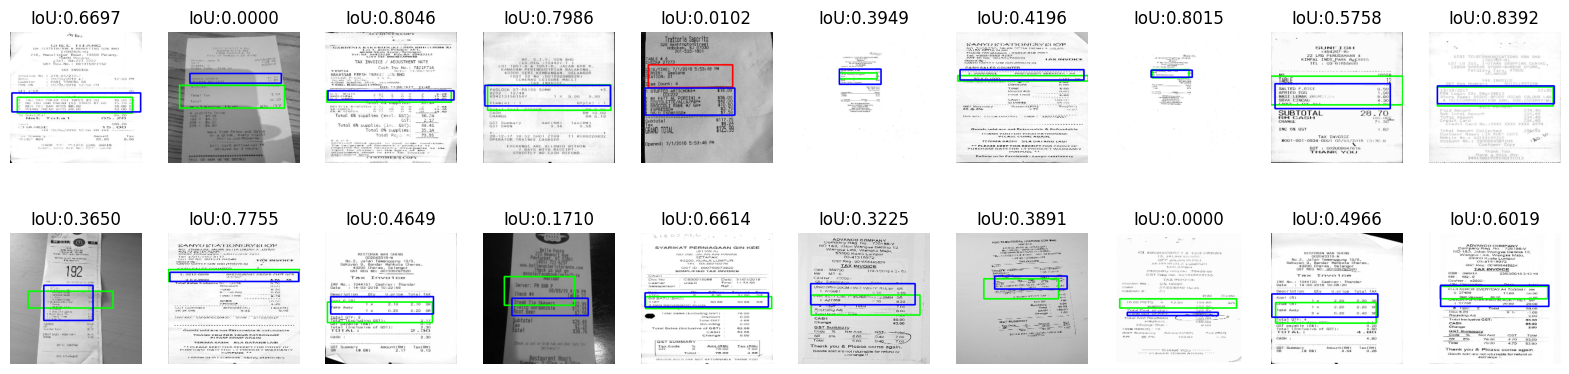

In [106]:
test_ds_2 = tune_test_ds(raw_test_ds_2) #change

plt.figure(figsize=(20, 10))

test_list_2 = list(test_ds_2.take(20).as_numpy_iterator()) #change

print(len(test_list_2)) #change

image, labels = test_list_2[0] #change

for i in range(len(test_list_2)): #change

    ax = plt.subplot(4, 10, i + 1)
    image, labels = test_list_2[i] #change

    predictions = model_2(image) #change

    predicted_box = predictions[1][0] * input_size
    predicted_box = tf.cast(predicted_box, tf.int32)

    predicted_label = predictions[0][0]

    image = image[0]

    actual_label = labels[0][0]
    actual_box = labels[1][0] * input_size
    actual_box = tf.cast(actual_box, tf.int32)

    image = image.astype("float") * 255.0
    image = image.astype(np.uint8)
    image_color = cv.cvtColor(image, cv.COLOR_GRAY2RGB)

    color = (255, 0, 0)
    # print box red if predicted and actual label do not match
    if (predicted_label[0] > 0.5 and actual_label[0] > 0) or (predicted_label[0] < 0.5 and actual_label[0] == 0):
        color = (0, 255, 0)

    cv.rectangle(image_color, predicted_box.numpy(), color, 2)
    cv.rectangle(image_color, actual_box.numpy(), (0, 0, 255), 2)

    IoU = intersection_over_union(predicted_box.numpy(), actual_box.numpy())

    plt.title("IoU:" + format(IoU, '.4f'))
    plt.imshow(image_color)
    plt.axis("off")

In [115]:
def obj_detect_2(image_path): #
    image_path = path_norm(image_path)
    img = cv.imread(image_path, cv.IMREAD_GRAYSCALE)

    #preprocess image
    height, width = img.shape 
    max_size = max(height, width)
    r = max_size / input_size
    new_width = int(width / r)
    new_height = int(height / r)
    new_size = (new_width, new_height)
    resized = cv.resize(img, new_size, interpolation= cv.INTER_LINEAR)
    new_image = np.zeros((input_size, input_size), dtype=np.uint8)
    new_image[0:new_height, 0:new_width] = resized

    #second preprocessing
    X = [] 
    new_image = new_image.astype(float) / 255.

    X.append(new_image)

    #third preprocessing
    X = np.array(X)
    
    X = np.expand_dims(X, axis=3)

    X = tf.convert_to_tensor(X, dtype=tf.float32)

    result = X
    #fourth preprocessing 
    predictions = model_2(result) #change

    predicted_box = abs(predictions[1][0] * max_size)
    
    predicted_box = tf.cast(predicted_box, tf.int32)
    
    temp_color_img = cv.cvtColor(img, cv.COLOR_GRAY2RGB)

    temp_color_img = cv.rectangle(temp_color_img, predicted_box.numpy(), color, 2)

    plt.imshow(temp_color_img)
    plt.axis("off")
    plt.show()
    
    return(predicted_box)

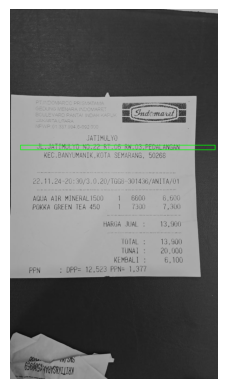

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 45, 588, 842,  21])>

In [116]:
obj_detect_2(r'C:\Users\dzaki\Downloads\test_indomaret.jpeg')

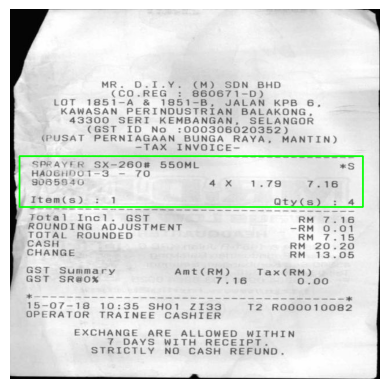

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 16, 254, 595,  89])>

In [117]:
obj_detect_2(r'C:\Users\dzaki\Downloads\test_indomaret2.jpg')

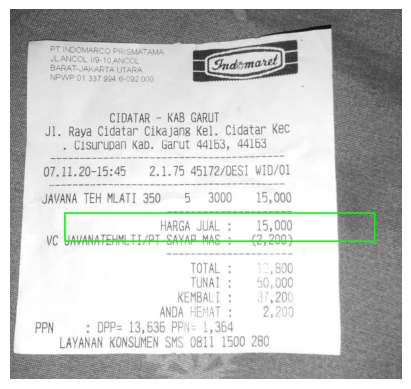

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 99, 369, 562,  52])>

In [118]:
obj_detect_2(r'C:\Users\dzaki\Downloads\test_indomaret3.jpg')

<h2>Building Model for Total Price</h2>

In [147]:
def data_load_special(files, full_data_path = "./obj/", image_ext = ".jpg"):
    X = []
    Y = []

    for file in files:
        img = cv.imread(os.path.join(full_data_path, file + image_ext), cv.IMREAD_GRAYSCALE)

        k = 1

        with open(full_data_path + "/" + file + ".txt", 'r') as fp: 
            line = fp.readlines()[-1]
            if line[0] == '0':
                k = 0

            box = np.array(line[1:].split(), dtype=float)

        img, box = format_image(img, box)
        img = img.astype(float) / 255.
        box = np.asarray(box, dtype=float) / input_size
        label = np.append(box, k)

        X.append(img)
        Y.append(label)

    X = np.array(X)
    
    X = np.expand_dims(X, axis=3)

    X = tf.convert_to_tensor(X, dtype=tf.float32)

    Y = tf.convert_to_tensor(Y, dtype=tf.float32)

    result = tf.data.Dataset.from_tensor_slices((X, Y))

    return result

In [148]:
line_to_be_read = 3
raw_train_ds_3 = data_load_special(training_files)
raw_validation_ds_3 = data_load_special(validation_files)
raw_test_ds_3 = data_load_special(test_files)

In [149]:
train_ds_3 = tune_training_ds(raw_train_ds_3)
validation_ds_3 = tune_validation_ds(raw_validation_ds_3)

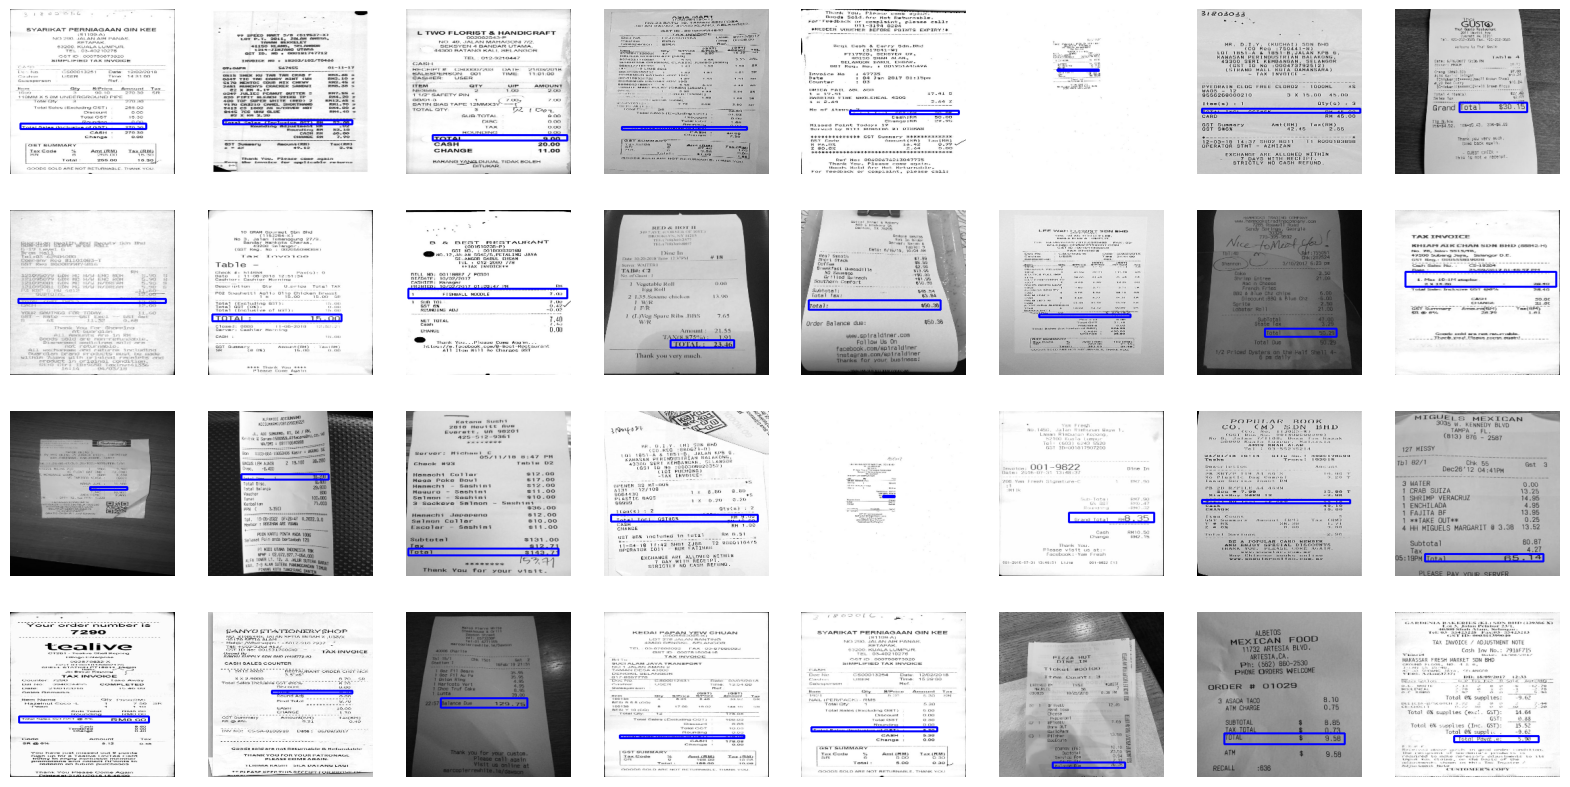

In [150]:
plt.figure(figsize=(20, 10))
for images, labels in train_ds_3.take(1): #change
    for i in range(BATCH_SIZE):
        ax = plt.subplot(4, BATCH_SIZE//4, i + 1)
        label = labels[0][i]
        box = (labels[1][i] * input_size)
        box = tf.cast(box, tf.int32)

        image = images[i].numpy().astype("float") * 255.0
        image = image.astype(np.uint8)
        image_color = cv.cvtColor(image, cv.COLOR_GRAY2RGB)

        color = (0, 0, 255)
        if label[0] > 0:
            color = (0, 255, 0)

        cv.rectangle(image_color, box.numpy(), color, 2)

        plt.imshow(image_color)
        plt.axis("off")

In [151]:
model_3 = build_model(tf.keras.layers.Input(shape=(input_size, input_size, 1,)))

model_3.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)   │ (None, 244, 244, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_33 (Conv2D)            │ (None, 242, 242, 16)      │             160 │ input_layer_21[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ average_pooling2d_33          │ (None, 121, 121, 16)      │               0 │ conv2d_33[0][0]            │
│ (AveragePooling2D)            │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_34 (Conv2D)            │ (None, 119, 119, 32)      │           4,640 │ average_pooling2d_33[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ average_pooling2d_34          │ (None, 59, 59, 32)        │               0 │ conv2d_34[0][0]            │
│ (AveragePooling2D)            │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_35 (Conv2D)            │ (None, 57, 57, 64)        │          18,496 │ average_pooling2d_34[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_10 (Dropout)          │ (None, 57, 57, 64)        │               0 │ conv2d_35[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ average_pooling2d_35          │ (None, 28, 28, 64)        │               0 │ dropout_10[0][0]           │
│ (AveragePooling2D)            │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_11 (Flatten)          │ (None, 50176)             │               0 │ average_pooling2d_35[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_12 (Dense)              │ (None, 64)                │       3,211,328 │ flatten_11[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ classifier_head (Dense)       │ (None, 2)                 │             130 │ dense_12[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ regressor_head (Dense)        │ (None, 4)                 │             260 │ dense_12[0][0]             │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 3,235,014 (12.34 MB)

 Trainable params: 3,235,014 (12.34 MB)

 Non-trainable params: 0 (0.00 B)

In [152]:
EPOCHS = 100

history = model_3.fit(train_ds_3, #change
                    steps_per_epoch=(len(training_files) // BATCH_SIZE),
                    validation_data=validation_ds_3, validation_steps=1, #change
                    epochs=EPOCHS,
                    verbose=1)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 250ms/step - classifier_head_accuracy: 0.7965 - classifier_head_loss: 0.2056 - loss: 0.8607 - regressor_head_loss: 0.6551 - regressor_head_mse: 0.6551 - val_classifier_head_accuracy: 1.0000 - val_classifier_head_loss: 0.0101 - val_loss: 0.0588 - val_regressor_head_loss: 0.0487 - val_regressor_head_mse: 0.0487
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 241ms/step - classifier_head_accuracy: 0.9970 - classifier_head_loss: 0.0199 - loss: 0.0564 - regressor_head_loss: 0.0365 - regressor_head_mse: 0.0365 - val_classifier_head_accuracy: 1.0000 - val_classifier_head_loss: 0.0048 - val_loss: 0.0281 - val_regressor_head_loss: 0.0232 - val_regressor_head_mse: 0.0232
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 241ms/step - classifier_head_accuracy: 0.9987 - classifier_head_loss: 0.0106 - loss: 0.0371 - regressor_head_loss: 0.0265 - regressor_head_mse: 0.0265 - val_classifier_head_accuracy: 1.0000 - val_classifier_head_loss: 0.0017 - val_loss: 0.0281 - val_re

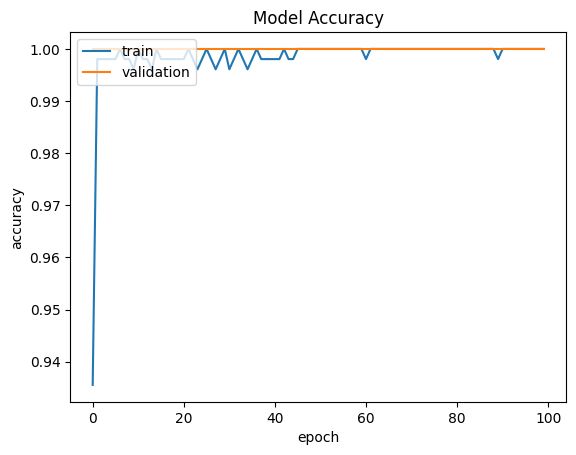

In [153]:
plt.plot(history.history['classifier_head_accuracy'])
plt.plot(history.history['val_classifier_head_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

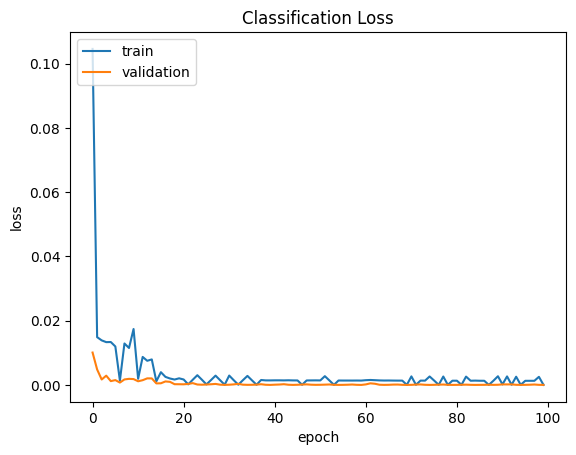

In [154]:
plt.plot(history.history['classifier_head_loss'])
plt.plot(history.history['val_classifier_head_loss'])
plt.title('Classification Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

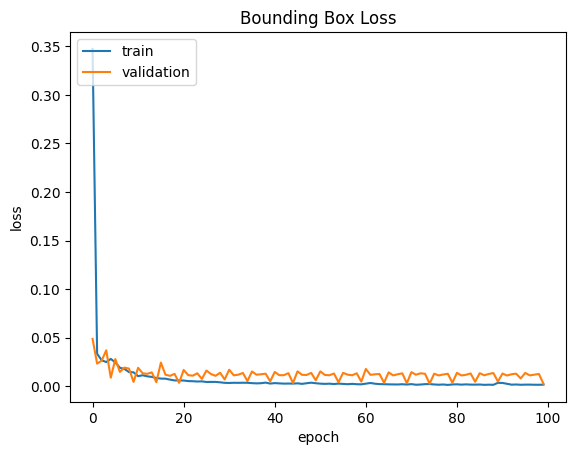

In [155]:
plt.plot(history.history['regressor_head_loss'])
plt.plot(history.history['val_regressor_head_loss'])
plt.title('Bounding Box Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

20


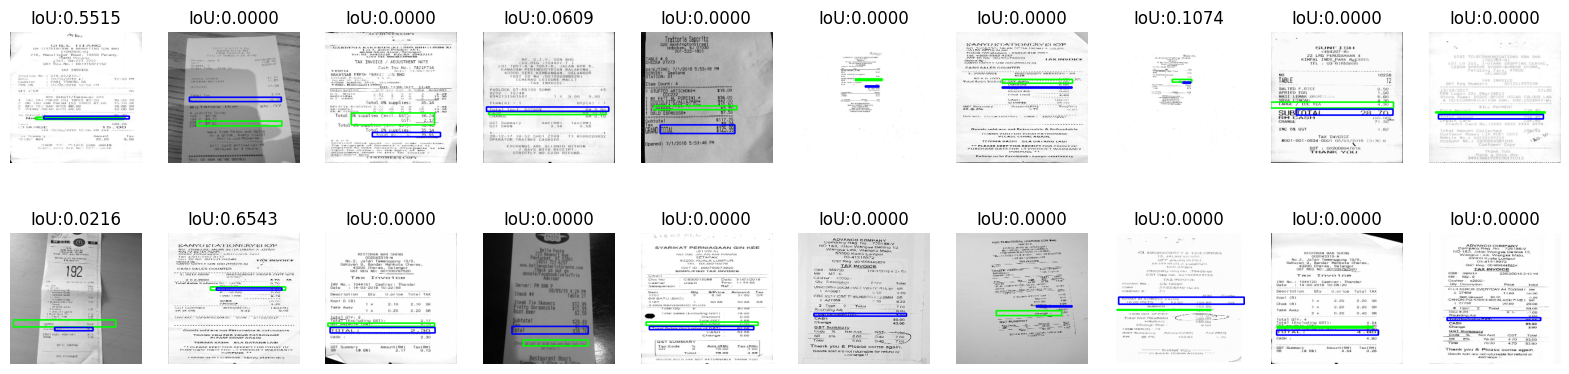

In [156]:
test_ds_3 = tune_test_ds(raw_test_ds_3) #change

plt.figure(figsize=(20, 10))

test_list_3 = list(test_ds_3.take(20).as_numpy_iterator()) #change

print(len(test_list_3)) #change

image, labels = test_list_3[0] #change

for i in range(len(test_list_3)): #change

    ax = plt.subplot(4, 10, i + 1)
    image, labels = test_list_3[i] #change

    predictions = model_3(image) #change

    predicted_box = predictions[1][0] * input_size
    predicted_box = tf.cast(predicted_box, tf.int32)

    predicted_label = predictions[0][0]

    image = image[0]

    actual_label = labels[0][0]
    actual_box = labels[1][0] * input_size
    actual_box = tf.cast(actual_box, tf.int32)

    image = image.astype("float") * 255.0
    image = image.astype(np.uint8)
    image_color = cv.cvtColor(image, cv.COLOR_GRAY2RGB)

    color = (255, 0, 0)
    # print box red if predicted and actual label do not match
    if (predicted_label[0] > 0.5 and actual_label[0] > 0) or (predicted_label[0] < 0.5 and actual_label[0] == 0):
        color = (0, 255, 0)

    cv.rectangle(image_color, predicted_box.numpy(), color, 2)
    cv.rectangle(image_color, actual_box.numpy(), (0, 0, 255), 2)

    IoU = intersection_over_union(predicted_box.numpy(), actual_box.numpy())

    plt.title("IoU:" + format(IoU, '.4f'))
    plt.imshow(image_color)
    plt.axis("off")

<h2>Combining the Model</h2>

In [168]:
def obj_detect_all(image_path): #
    image_path = path_norm(image_path)
    img = cv.imread(image_path, cv.IMREAD_GRAYSCALE)

    #preprocess image
    height, width = img.shape 
    max_size = max(height, width)
    r = max_size / input_size
    new_width = int(width / r)
    new_height = int(height / r)
    new_size = (new_width, new_height)
    resized = cv.resize(img, new_size, interpolation= cv.INTER_LINEAR)
    new_image = np.zeros((input_size, input_size), dtype=np.uint8)
    new_image[0:new_height, 0:new_width] = resized

    #second preprocessing
    X = [] 
    new_image = new_image.astype(float) / 255.

    X.append(new_image)

    #third preprocessing
    X = np.array(X)
    
    X = np.expand_dims(X, axis=3)

    X = tf.convert_to_tensor(X, dtype=tf.float32)

    result = X
    #fourth preprocessing
    predictions = model(result) #change
    predictions1 = model_1(result) #change
    predictions2 = model_2(result) #change
    predictions3 = model_3(result) #change

    predicted_box = abs(predictions[1][0] * max_size)
    predicted_box1 = abs(predictions1[1][0] * max_size)
    predicted_box2 = abs(predictions2[1][0] * max_size)
    predicted_box3 = abs(predictions3[1][0] * max_size)
    
    predicted_box = tf.cast(predicted_box, tf.int32)
    predicted_box1 = tf.cast(predicted_box1, tf.int32)
    predicted_box2 = tf.cast(predicted_box2, tf.int32)
    predicted_box3 = tf.cast(predicted_box3, tf.int32)
    
    temp_color_img = cv.cvtColor(img, cv.COLOR_GRAY2RGB)

    cv.rectangle(temp_color_img, predicted_box.numpy(), (255,255,0), 2) #struk
    cv.rectangle(temp_color_img, predicted_box1.numpy(), (128,0,156), 2) #info toko
    cv.rectangle(temp_color_img, predicted_box2.numpy(), (255,0,0), 2) #item belanja
    cv.rectangle(temp_color_img, predicted_box3.numpy(), (0,56,56), 2) #total

    plt.imshow(temp_color_img)
    plt.axis("off")
    plt.show()
    
    return(predicted_box)

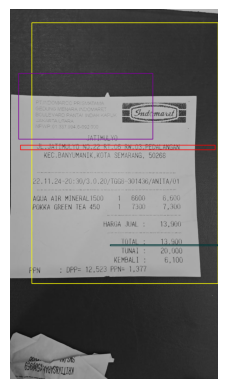

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([  94,   59, 1044, 1128])>

In [169]:
obj_detect_all(r'C:\Users\dzaki\Downloads\test_indomaret.jpeg')

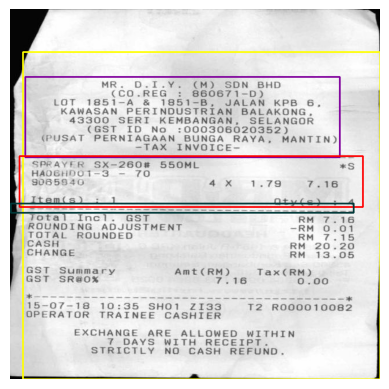

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 22,  74, 679, 568])>

In [170]:
obj_detect_all(r'C:\Users\dzaki\Downloads\test_indomaret2.jpg')

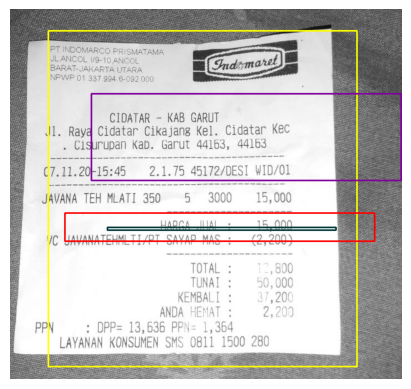

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 69,  39, 560, 609])>

In [171]:
obj_detect_all(r'C:\Users\dzaki\Downloads\test_indomaret3.jpg')